## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Get the Stock Data from Yahoo Finance

In [2]:
ticker = "AAPL" # Example: Apple Inc.
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
data = yf.download(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-21,23.747499,23.750000,23.430000,23.485001,20.773312,156316000
2014-07-22,23.670000,23.722500,23.530001,23.680000,20.945791,220788000
2014-07-23,23.855000,24.469999,23.792500,24.297501,21.491999,371672000
2014-07-24,24.260000,24.330000,24.105000,24.257500,21.456619,182916000
2014-07-25,24.212500,24.459999,24.160000,24.417500,21.598139,173876000


## Data Cleaning

In [4]:
data.reset_index(inplace=True)
data = data[["Date", "Close"]]
data = data.dropna()
data.index = data.pop("Date")

data

,Close
Date,
2014-07-21,23.485001
2014-07-22,23.680000
2014-07-23,24.297501
2014-07-24,24.257500
2014-07-25,24.417500
...,...
2024-07-12,230.539993
2024-07-15,234.399994
2024-07-16,234.820007


## Plot the closing price for a Stock over past 10 years

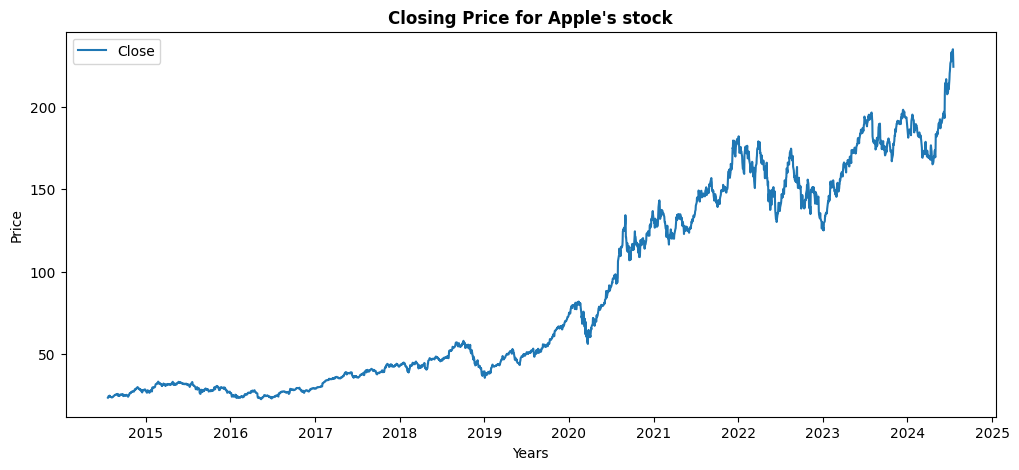

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Close"])
plt.xlabel("Years")
plt.ylabel("Price")
plt.title("Closing Price for Apple's stock", weight="bold")
plt.legend(["Close"], loc="upper left")

## Plot for Closing Price vs Moving Average of 100 and 200 days

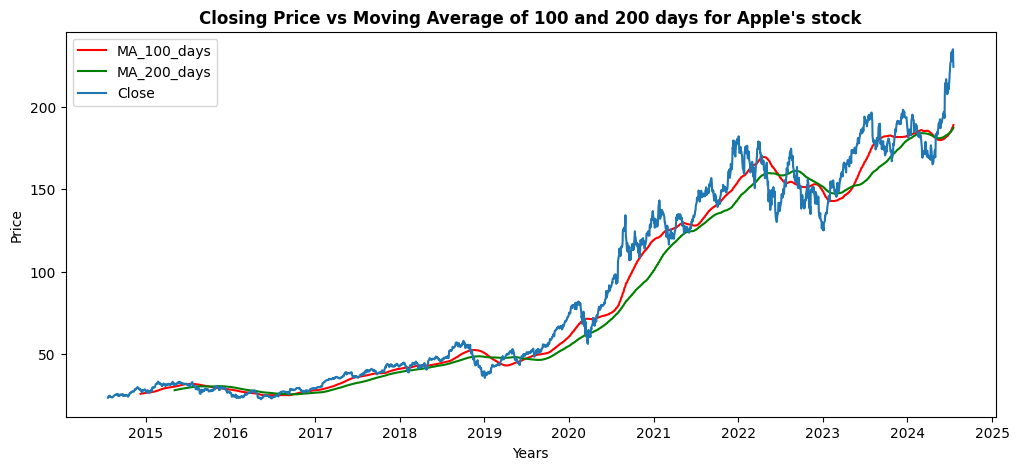

In [6]:
data["MA_100_days"] = data["Close"].rolling(window=100).mean()
data["MA_200_days"] = data["Close"].rolling(window=200).mean()

plt.figure(figsize=(12, 5))
plt.plot(data.index, data["MA_100_days"], 'r')
plt.plot(data.index, data["MA_200_days"], 'g')
plt.plot(data.index, data["Close"])
plt.xlabel("Years")
plt.ylabel("Price")
plt.title("Closing Price vs Moving Average of 100 and 200 days for Apple's stock", weight="bold")
plt.legend(["MA_100_days", "MA_200_days", "Close"], loc="upper left")

## Plot Percentage change in Closing Price

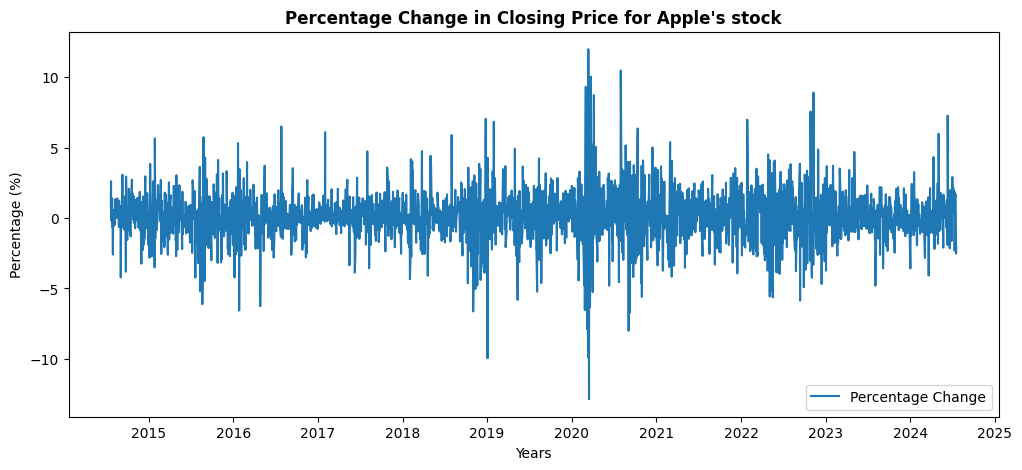

In [7]:
data["percentage_change_close"] = data["Close"].pct_change()*100

plt.figure(figsize=(12, 5))
plt.plot(data.index, data["percentage_change_close"])
plt.xlabel("Years")
plt.ylabel("Percentage (%)")
plt.title("Percentage Change in Closing Price for Apple's stock", weight="bold")
plt.legend(["Percentage Change"], loc="lower right")

## Data Scaling

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

## Function to create dataset by grouping 100 days of data

In [9]:
def create_dataset(data, time_step=1):
  X, y = [], []

  for i in range(100, data.shape[0]):
    X.append(data[i-time_step:i])
    y.append(data[i, 0])

  return np.array(X), np.array(y)

## Create and Reshape the dataset

In [10]:
time_step = 100
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)  # reshape input to the format expected by the LSTM model
X.shape, y.shape

((2416, 100, 1), (2416,))

## Divide dataset in training (80%) and testing (20%)

In [11]:
split_len = int(len(X) * 0.8)
X_train, X_test = X[:split_len], X[split_len:]
y_train, y_test = y[:split_len], y[split_len:]

In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1932, 100, 1) (1932,)
(484, 100, 1) (484,)


## Generate Model

In [13]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model on Training Data

In [16]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
31/31 [==============================] - 12s 174ms/step - loss: 0.0172
Epoch 2/50
31/31 [==============================] - 8s 274ms/step - loss: 6.8509e-04
Epoch 3/50
31/31 [==============================] - 5s 171ms/step - loss: 4.5588e-04
Epoch 4/50
31/31 [==============================] - 6s 195ms/step - loss: 4.8495e-04
Epoch 5/50
31/31 [==============================] - 6s 199ms/step - loss: 4.4196e-04
Epoch 6/50
31/31 [==============================] - 5s 173ms/step - loss: 4.3271e-04
Epoch 7/50
31/31 [==============================] - 7s 227ms/step - loss: 4.5241e-04
Epoch 8/50
31/31 [==============================] - 5s 171ms/step - loss: 4.1938e-04
Epoch 9/50
31/31 [==============================] - 7s 220ms/step - loss: 3.8634e-04
Epoch 10/50
31/31 [==============================] - 6s 188ms/step - loss: 4.0771e-04
Epoch 11/50
31/31 [==============================] - 6s 205ms/step - loss: 3.8593e-04
Epoch 12/50
31/31 [==============================] - 7s 239ms/step

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Get the predictions from trained model

In [15]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


## Inverse Scale and Reshape the final predictions

In [16]:
final_predictions_train = scaler.inverse_transform(predictions_train.reshape(-1, 1))
final_y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

final_predictions_test = scaler.inverse_transform(predictions_test.reshape(-1 ,1))
final_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

## Actual vs Predicted Closing Price (Training Data)

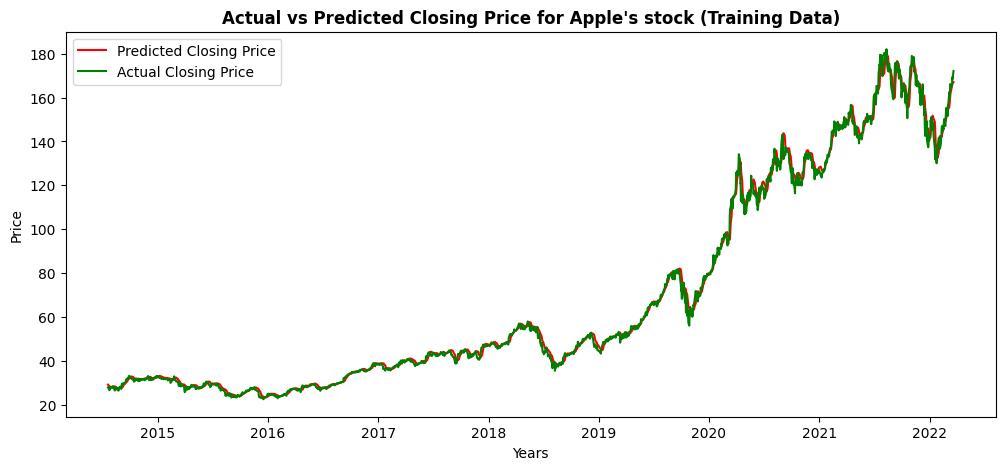

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(data.index[:split_len], final_predictions_train, 'r')
plt.plot(data.index[:split_len], final_y_train, 'g')
plt.xlabel("Years")
plt.ylabel("Price")
plt.title("Actual vs Predicted Closing Price for Apple's stock (Training Data)", weight="bold")
plt.legend(["Predicted Closing Price", "Actual Closing Price"], loc="upper left")

## Actual vs Predicted Closing Price (Test Data)

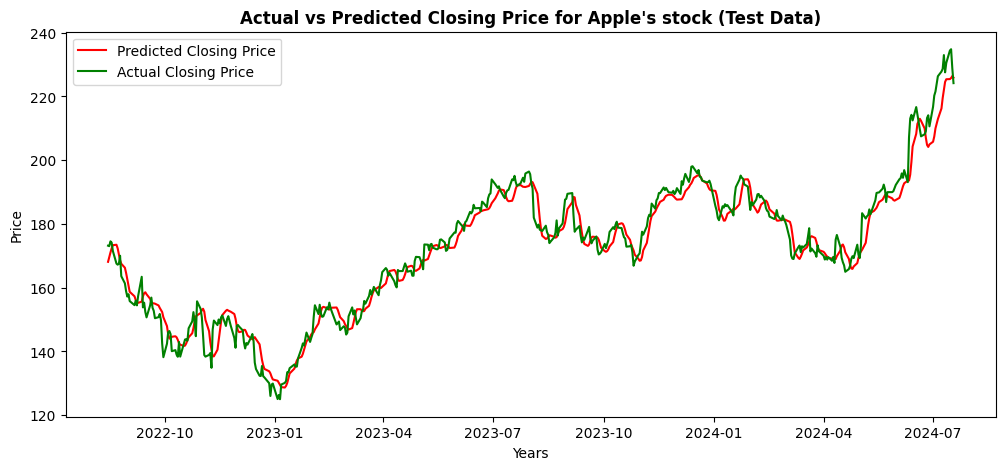

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(data.index[split_len+time_step:], final_predictions_test, 'r')
plt.plot(data.index[split_len+time_step:], final_y_test, 'g')
plt.xlabel("Years")
plt.ylabel("Price")
plt.title("Actual vs Predicted Closing Price for Apple's stock (Test Data)", weight="bold")
plt.legend(["Predicted Closing Price", "Actual Closing Price"], loc="upper left")

## Calculate Accuracy Matrix

In [19]:
mape_train = mean_absolute_percentage_error(final_y_train, final_predictions_train) * 100
mape_test = mean_absolute_percentage_error(final_y_test, final_predictions_test) * 100

print(f"Mean Absolute Percentage Error (MAPE) for Training Data: {mape_train:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE) for Testing Data: {mape_test:.2f}%")

Mean Absolute Percentage Error (MAPE) for Training Data: 2.32%
Mean Absolute Percentage Error (MAPE) for Testing Data: 1.99%


## Save the Model to Generate Web App

In [20]:
model.save("Stock_Price_Trend_Predictor.keras")

## Predict next day's closing price

In [21]:
last_100_days = scaled_data[-time_step:]
last_100_days = last_100_days.reshape(1, time_step, 1)

next_day_prediction = model.predict(last_100_days)
next_day_prediction = scaler.inverse_transform(next_day_prediction)

last_closing_price = data["Close"].values[-1]
if next_day_prediction[0][0] > last_closing_price:
  trend = f"The {ticker}'s closing price is predicted to go up on the next trading day."
elif next_day_prediction[0][0] < last_closing_price:
  trend = f"The {ticker}'s closing price is predicted to go down on the next trading day."
else:
  trend = f"The {ticker}'s closing price is predicted to remain the same on the next trading day."

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


## Display Estimated Trend

In [22]:
print("Stock Price Trend Prediction:")
print(trend)

Stock Price Trend Prediction:
The AAPL's closing price is predicted to go down on the next trading day.


## Display Next Day's Estimated Closing Price

In [23]:
print(f"Next trading day's estimated closing price for {ticker}: {next_day_prediction[0][0]: 0.2f}")

Next trading day's estimated closing price for AAPL:  223.76
